In [96]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### MNISTデータのダウンロードと読み込み

In [97]:
#from tensorflow.examples.tutorials.mnist  import  input_data
mnist = input_data.read_data_sets('../99.MNIST_data')

Extracting ../99.MNIST_data/train-images-idx3-ubyte.gz
Extracting ../99.MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../99.MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../99.MNIST_data/t10k-labels-idx1-ubyte.gz


### モデル作成

In [98]:
# real_dim : 本物データの次元
# z_dim : フェイクデータの次元
def model_imputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [99]:
### generator関数
# reuse : False 呼び出すたびに、関数のなかの前回実行時の値を保持するかどうかを指定
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1) # Leaky ReLU
        
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out 

In [100]:
### discriminator関数の定義
# reuse : False 呼び出すたびに、関数のなかの前回実行時の値を保持するかどうかを指定
def discriminator(z, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse): # discriminatorと名前をつけて呼ばれた場合は前回の演算の値を保持する
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1) # Leaky ReLU
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits
    

In [101]:
### パイパーパラメータの初期化
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1


In [102]:
# モデルを定義
tf.reset_default_graph()

input_real, input_z = model_imputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)


In [103]:
# 損失関数を定義（D/G）
# 正解から離れていると値が大きく発散する
d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                      labels=tf.ones_like(d_logits_real) *(1-smooth)))
d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                      labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real  + d_loss_fake

# ランダムに生成された画像が本物として認識された誤差
g_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)))


In [104]:
# 最適化手法を定義
learning_rate = 0.002

t_vars = tf.trainable_variables() # weight / bias を取り出す

g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)


### バッチデータの確認

In [47]:
batch_size = 100
batch = mnist.train.next_batch(batch_size)

In [70]:
batch[0] # ピクセルデータ


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [72]:
batch[1] # ラベルデータ

array([8, 4, 7, 4, 2, 5, 0, 0, 5, 3, 5, 8, 9, 4, 5, 1, 7, 3, 3, 0, 7, 6, 4,
       1, 3, 8, 3, 5, 5, 0, 8, 9, 8, 5, 0, 5, 4, 4, 0, 4, 1, 5, 5, 0, 0, 9,
       9, 6, 3, 8, 1, 2, 2, 4, 0, 6, 4, 5, 5, 3, 7, 6, 3, 1, 6, 0, 6, 4, 6,
       7, 1, 6, 6, 6, 0, 3, 2, 1, 0, 0, 6, 9, 3, 6, 4, 7, 2, 7, 0, 0, 1, 8,
       3, 8, 3, 9, 7, 3, 4, 9], dtype=uint8)

### トレーニングの実行

In [106]:
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range (mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images =  batch[0].reshape((batch_size, 784))
            batch_images =  batch_images * 2 -1 # -1〜1の範囲に変換
            
            # Generator
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            _ = sess.run(d_train_optimize, feed_dict={input_real : batch_images,  input_z: batch_z})
            _ = sess.run(g_train_optimize, feed_dict={input_z : batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z : batch_z, input_real : batch_images})
        train_loss_g = g_loss.eval({input_z : batch_z})
        
        print ("epoch {}/{}".format(e+1, epochs),
               "Discriminator loss : {:.4f}".format(train_loss_d),
               "Generator loss : {:.4f}".format(train_loss_g))
        
        losses.append((train_loss_d,  train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                              feed_dict={input_z: sample_z})
        
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        
with open('training_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

    

epoch 1/100 Discriminator loss : 0.3498 Generator loss : 4.0542
epoch 2/100 Discriminator loss : 0.4084 Generator loss : 3.8620
epoch 3/100 Discriminator loss : 0.4670 Generator loss : 3.1155
epoch 4/100 Discriminator loss : 1.1924 Generator loss : 9.3471
epoch 5/100 Discriminator loss : 1.1594 Generator loss : 5.7142
epoch 6/100 Discriminator loss : 0.9736 Generator loss : 1.6287
epoch 7/100 Discriminator loss : 0.6964 Generator loss : 3.0794
epoch 8/100 Discriminator loss : 0.9063 Generator loss : 2.6686
epoch 9/100 Discriminator loss : 1.5219 Generator loss : 1.5159
epoch 10/100 Discriminator loss : 0.7601 Generator loss : 2.2880
epoch 11/100 Discriminator loss : 0.9341 Generator loss : 2.3508
epoch 12/100 Discriminator loss : 1.1060 Generator loss : 2.7784
epoch 13/100 Discriminator loss : 1.2590 Generator loss : 1.7820
epoch 14/100 Discriminator loss : 1.7088 Generator loss : 2.7429
epoch 15/100 Discriminator loss : 1.5709 Generator loss : 1.9200
epoch 16/100 Discriminator loss : 

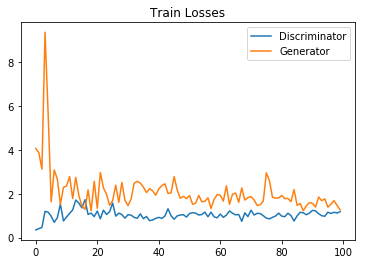

In [139]:
# 学習結果（損失関数）の可視化
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0],  label='Discriminator') # 転置をして
plt.plot(losses.T[1], label='Generator')
plt.title('Train Losses')

plt.legend()


### 途中経過の可視化

In [133]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):       
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        
    return fig, axes
    

In [134]:
with open ('training_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    

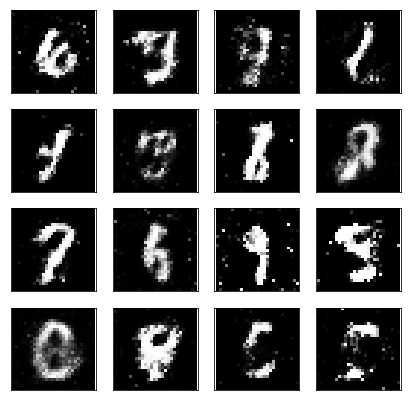

In [141]:
_ = view_samples(69, samples)

In [137]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize)

In [138]:
rows

10